## Book to download and store schedule table from college hockey news


### Dependencies and Setup
- 

In [12]:
## This workbook is used to scrape the data from the College Hockey News and explore the data## 

######## DONT SEEM TO BE ENFORCED ########
## Notes - the site's robots.txt file sets these limits for crawlers
# Crawl-delay: 10 (seconds)
# Request-rate: 1/5 (5 requests every minute)

# Dependencies
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import json

# Set the URL to scrape
url_base = 'https://www.collegehockeynews.com/schedules/?season=' # Link to the 2022-2023 season with all results

#### THESE NEED TO BE UPDATED EACH SEASON ####
#### Set the season varriable portion of the url 
url_season = '20232024'
#### string to add to file names and whatnote
file_tage = 'Current Season 2023'

############# Set the output folder
# temp_output_dir = '../TEMP/results/'
final_output_dir = '../data/schedule_results/'

## Construction teh url to feel to parser
url = url_base + url_season


## Request the page and parse the html for the Schedule Table

- table structure requires that we extract information about things like the data for the contest and Conference to note has to be extracted from header rows withing the larger table.
    - Overcome this by looking at the html row by row and store the data from the headers to apply to the rows found below it

In [13]:
# Get the page with requests
response = requests.get(url)

# Create a BeautifulSoup object
soup = BeautifulSoup(response.text, 'html.parser')

# select the table or tables
tables = soup.find_all('table')

# Initialize variables
current_date = None
current_conference = None
game_notes = None

# Initialize an empty list to hold the data
data = []

# Parse the table with BeautifulSoup

rows = soup.find_all('tr')

# Loop through each row to find relevant information
for row in rows:
    # Check for date row
    if row.get('class') == ['stats-section']:
        current_date = row.find('td').text.strip()
    # Check for conference row
    elif row.get('class') == ['sked-header']:
        current_conference = row.find('td').text.strip()
    # Check for game notes
    elif len(row.find_all('td')) == 2:
        game_notes = row.find_all('td')[1].text.strip()
    # Process rows with game data
    elif row.get('valign') == 'top':
        cells = row.find_all('td')
        if len(cells) >= 9:
            home_team = cells[0].text.strip()
            home_team_link = cells[0].find('a')['href'] if cells[0].find('a') else None
            home_score = cells[1].text.strip()
            away_team = cells[3].text.strip()
            away_team_link = cells[3].find('a')['href'] if cells[3].find('a') else None
            away_score = cells[4].text.strip()
            ot = cells[5].text.strip()
            box_link = cells[7].find('a')['href'] if cells[7].find('a') else None
            metrics_link = cells[8].find('a')['href'] if cells[8].find('a') else None
             # Capture Game Notes
            game_notes_cell = cells[-1].find('small')
            game_notes = game_notes_cell.text.strip() if game_notes_cell else None

            # Append data to the list
            data.append([current_date, current_conference, game_notes, home_team, home_team_link, home_score, away_team, away_team_link, away_score, ot, box_link, metrics_link])
            game_notes = None  # Reset game notes for the next row
            

# Create a DataFrame
columns = ['Date', 'Conference', 'Game_Notes', 'Away_Team', 'Away_Team_Link', 'Away_Score', 'Home_Team', 'Home_Team_Link', 'Home_Score',  'OT', 'Box_Link', 'Metrics_Link']
df = pd.DataFrame(data, columns=columns)



## Do some light data transformation

In [14]:
## Extract the day of the week from the date and save in new column
df['Day'] = pd.to_datetime(df['Date']).dt.day_name()
# remove day of the week from date
# format data column as YYYY-MM-DD
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

### Create a new column for the game ID
## Game ID will be a combination of the date and abbreviated team names

# Function to abbreviate the team names
for row in df.itertuples():
    home_team = row.Home_Team
    away_team = row.Away_Team
    home_team_abbr = home_team.split(' ')[-1]
    away_team_abbr = away_team.split(' ')[-1]
    game_id = f'{row.Date}_{home_team_abbr}_{away_team_abbr}'
    df.loc[row.Index, 'Game_ID'] = game_id

# Create a new column for the game ID
df['Game_ID'] = df['Game_ID'].str.replace(',', '')

# Apply the function to the DataFrame
df['Game_ID'] = df.apply(lambda row: f'{row.Date}_{row.Home_Team}_{row.Away_Team}', axis=1)


C:\Users\Justin\AppData\Local\Temp\ipykernel_7552\2220396521.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2023-10-06_State_Arizona' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row.Index, 'Game_ID'] = game_id


In [15]:
# ### Look at Output

# df.head()

# df.sample(10)

# df.info()

### Save the Dataframe collected to a CSV file 
- use the dir variable to put it in temp file or final data folder

In [16]:
### OUTPUT A TEMP FILE TO THE TEMP FOLDER
# temp_file_name = f'{temp_output_dir}temp_schedule_results_{file_tage}.csv'
# df.to_csv(temp_file_name, index=False)

### OUTPUT A FINAL FILE TO THE DATA FOLDER AFTER MANUAL CHECKING
final_file_PATH = f'{final_output_dir}schedule_results_{file_tage}.csv'
df.to_csv(final_file_PATH, index=False)


## Load the Roster File to do some work

- Step 1 Load
- Step 2 - take the DOB column and convert it into age in days and age in years to make calculations easier

In [17]:
roster_path = '../data/rosters/2023_master_roster.csv'

# Read in the roster file
roster_df = pd.read_csv(roster_path)

## Convert and store age as number of days old
roster_df['Age'] = pd.to_datetime(roster_df['DOB']).dt.strftime('%Y-%m-%d')
roster_df['Age_Days'] = pd.to_datetime(roster_df['Age'])

## Calculate age in days
roster_df['Age_Days'] = pd.to_datetime('today') - roster_df['Age_Days']

# Simplify the Age_Days to just the number of days
roster_df['Age_Days'] = roster_df['Age_Days'].dt.days

# Create Age_Years column with float values
roster_df['Age_Years'] = roster_df['Age_Days'] / 365.25

# LOOK AT DATA
roster_df.head()

,Unnamed: 0,No.,Name,Yr.,Ht.,Wt.,DOB,Hometown,Position,Height_Inches,Draft_Year,NHL_Team,D_Round,Last Team,League,School,Age,Age_Days,Age_Years
0,NaN,23,"Angesved, Theo",Fr,5-10,172,6/23/2003,"Växjö, Sweden",Defensemen,70,NaN,NaN,NaN,Frölunda HC J20,SWE,American-Intl,2003-06-23,7429,20.339493
1,NaN,4,"Callahan, Brett",Gr,5-10,182,10/16/1998,"Westmont, Ill.",Defensemen,70,NaN,NaN,NaN,Jersey Hitmen,USPHL,American-Intl,1998-10-16,9140,25.023956
2,NaN,7,"Kramer, Brian",Sr,5-11,181,7/20/2000,"Wexford, Pa.",Defensemen,71,NaN,NaN,NaN,Fargo,USHL,American-Intl,2000-07-20,8497,23.263518
3,NaN,5,"Leppanen, Tomi",Fr,6-1,190,4/7/2003,"Heinola, Finland",Defensemen,73,NaN,NaN,NaN,Sioux City,USHL,American-Intl,2003-04-07,7506,20.550308
4,NaN,20,"McCurdy, Hunter",So,6-1,220,8/9/2001,"Mokena, Ill.",Defensemen,73,NaN,NaN,NaN,Danbury,NAHL,American-Intl,2001-08-09,8112,22.209446


## AGG Team INFO V2

In [1]:
import pandas as pd
import numpy as np


def aggregate_team_info_v2(roster_df):
    """
    Aggregates team information including average age, average experience, 
    count of drafted players, and a draft quality metric. Each team will have
    a single row with additional columns for different positions.
    
    Parameters:
    - roster_df: DataFrame containing the roster information
    
    Returns:
    - final_df: DataFrame with aggregated team information
    """
    
    ###############################
    ### Handle Age and Experince Columns
    ##################################
    # Convert and store age as number of days old
    roster_df['Age'] = pd.to_datetime(roster_df['DOB']).dt.strftime('%Y-%m-%d')
    roster_df['Age_Days'] = pd.to_datetime(roster_df['Age'])
    
    # Calculate age in days
    roster_df['Age_Days'] = pd.to_datetime('today') - roster_df['Age_Days']
    
    # Simplify the Age_Days to just the number of days
    roster_df['Age_Days'] = roster_df['Age_Days'].dt.days
    
    # Create Age_Years column with float values
    roster_df['Age_Years'] = roster_df['Age_Days'] / 365.25
    
    # Map the 'Yr.' column to a numerical value
    yr_map = {'Fr': 0, 'So': 1, 'Jr': 2, 'Sr': 3, 'Gr': 4}
    roster_df['year_exp'] = roster_df['Yr.'].map(yr_map)
    # Drop the original 'Yr.' column
    roster_df.drop(columns='Yr.', inplace=True)

    
    # Group by School and calculate the mean age and experience
    team_avg_df = roster_df.groupby('School', as_index=False).agg({'Age_Years': 'mean', 'year_exp': 'mean'})
    
    # Group by School and Position and calculate the mean age and experience
    team_pos_avg_df = roster_df.groupby(['School', 'Position'], as_index=False).agg({'Age_Years': 'mean', 'year_exp': 'mean'})
    team_pos_avg_df = team_pos_avg_df.pivot(index='School', columns='Position').reset_index()
    team_pos_avg_df.columns = [f"{col[1]}_{col[0]}" if col[1] else col[0] for col in team_pos_avg_df.columns]
    
    ###############################
        ##  Handle Draft Columns
    ##################################

    # Create a column that indicates whether a player was drafted
    roster_df['Drafted'] = ~roster_df['Draft_Year'].isna()
    
    # Count the number of drafted players for each team
    draft_count_df = roster_df.groupby('School', as_index=False)['Drafted'].sum()
    
    ######################### ORIGINAL DRAFT SCORE CALCULATION ############################
    # # Create a draft quality metric based on the draft round
    # roster_df['Draft_Score'] = 1 / roster_df['D_Round'].replace({0: np.nan})
    
    # # Calculate the average draft quality score for each team
    # draft_quality_df = roster_df.groupby('School', as_index=False)['Draft_Score'].mean()
    ########################### END ORIGINAL DRAFT SCORE CALCULATION ############################

    ### NEW DRAFT SCORE CALCULATION ###
    # Assign weights to draft rounds
    draft_weights = {
        1: 8,  # Extra weight for 1st round
        2: 6,
        3: 5,
        4: 4,
        5: 3,
        6: 2,
        7: 1
    }

    # Compute player draft scores and fill NaNs with 0
    roster_df['Player_Draft_Score'] = roster_df['D_Round'].map(draft_weights).fillna(0)

    # Compute the team draft scores
    team_draft_score_df = roster_df.groupby('School')['Player_Draft_Score'].sum().reset_index()
    team_draft_score_df.columns = ['School', 'Team_Draft_Score']

    # Normalize the team draft scores
    max_score = team_draft_score_df['Team_Draft_Score'].max()
    min_score = team_draft_score_df['Team_Draft_Score'].min()
    team_draft_score_df['Normalized_Team_Draft_Score'] = (team_draft_score_df['Team_Draft_Score'] - min_score) / (max_score - min_score)

    # Merge the draft count and draft quality dataframes
    draft_df = pd.merge(draft_count_df, team_draft_score_df, on='School', how='outer')
    
    # Merge this with our previously merged data for a comprehensive dataframe
    final_df = pd.merge(team_avg_df, team_pos_avg_df, on='School', how='outer')
    final_df = pd.merge(final_df, draft_df, on='School', how='outer')

    # Replace '-' with ' ' in School column
    final_df['School'] = final_df['School'].str.replace('-', ' ')
    
    return final_df

# Test the function with the updated structure
team_roster_summary_df = aggregate_team_info_v2(roster_df)

print(f'Number of teams: {len(team_roster_summary_df)}')
team_roster_summary_df.head()


NameError: name 'roster_df' is not defined

In [19]:
### Save the Team Roster Summary to a CSV file
team_roster_summary_df.to_csv('../data/rosters/2023_team_roster_summary.csv', index=False)

## Find the matchups with the lowest combined average age and the lowest combined years experience. 

In [20]:
### Schedule Data
schedule_df = df.copy()

## Team Summary Data
team_summary_df = team_roster_summary_df.copy()

# It looks like the column names in the schedule dataframe are different than what we expected. 
# Let's adjust the column names and try the merge operation again.

# Merge the schedule dataframe with the team summary dataframe
# We merge twice: once for the 'Home_Team' and once for the 'Away_Team'
merged_df_home = pd.merge(schedule_df, team_summary_df, left_on='Home_Team', right_on='School', how='left')
merged_df = pd.merge(merged_df_home, team_summary_df, left_on='Away_Team', right_on='School', suffixes=('_Home', '_Away'), how='left')

# Calculate the combined age and experience for each matchup
merged_df['Combined_Age'] = merged_df['Age_Years_Home'] + merged_df['Age_Years_Away']
merged_df['Combined_Exp'] = merged_df['year_exp_Home'] + merged_df['year_exp_Away']

# Create a new DataFrame containing only the relevant columns for each matchup's combined age and experience
matchup_summary_df = merged_df[['Home_Team', 'Away_Team', 'Combined_Age', 'Combined_Exp']]

# drop NaNs
matchup_summary_df.dropna(inplace=True)

# Drop duplicate rows
matchup_summary_df.drop_duplicates(inplace=True)

# Sort by combined age
matchup_summary_df.sort_values(by='Combined_Age', inplace=True)
# Reset the index
matchup_summary_df.reset_index(drop=True, inplace=True)

matchup_summary_df.head(25)

# # Find the matchup with the lowest combined age
# lowest_combined_age_matchup = merged_df.loc[merged_df['Combined_Age'].idxmin()]
# lowest_combined_exp_matchup = merged_df.loc[merged_df['Combined_Exp'].idxmin()]

# lowest_combined_age_matchup[['Home_Team', 'Away_Team', 'Combined_Age']], lowest_combined_exp_matchup[['Home_Team', 'Away_Team', 'Combined_Exp']]


C:\Users\Justin\AppData\Local\Temp\ipykernel_7552\2582686023.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchup_summary_df.dropna(inplace=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_7552\2582686023.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchup_summary_df.drop_duplicates(inplace=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_7552\2582686023.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchup_

,Home_Team,Away_Team,Combined_Age,Combined_Exp
0,Harvard,Boston College,41.587329,2.502222
1,Boston College,Denver,41.596077,2.337607
2,Boston College,Michigan State,41.900778,2.518519
3,Boston College,Boston University,41.904747,2.900794
4,Boston University,Boston College,41.904747,2.900794
5,Notre Dame,Boston College,42.098771,2.877395
6,Boston College,Providence,42.133960,3.029915
7,Providence,Boston College,42.133960,3.029915
8,Cornell,Harvard,42.380929,2.530000
9,Harvard,Cornell,42.380929,2.530000


In [21]:
print(f'Number of Unique Matchups This Season: {len(matchup_summary_df)}')

# Save the matchup summary to a CSV file
matchup_summary_df.to_csv('../TEMP/2023_matchup_summary.csv', index=False)


Number of Unique Matchups This Season: 481


In [30]:
#### Unique Matchups

df = matchup_summary_df.copy()

# Create a new column containing sorted team matchups
df['Sorted_Matchup'] = df.apply(lambda row: tuple(sorted([row['Home_Team'], row['Away_Team']])), axis=1)

# Drop duplicate rows based on the 'Sorted_Matchup' column
df_unique_matchups = df.drop_duplicates(subset=['Sorted_Matchup'])

# Show the first few rows of the DataFrame with unique matchups
print(f'Number of Unique Matchups This Season: {len(df_unique_matchups)}')
df_unique_matchups.head(20)



Number of Unique Matchups This Season: 319


,Home_Team,Away_Team,Combined_Age,Combined_Exp,Sorted_Matchup
0,Harvard,Boston College,41.587329,2.502222,"(Boston College, Harvard)"
1,Boston College,Denver,41.596077,2.337607,"(Boston College, Denver)"
2,Boston College,Michigan State,41.900778,2.518519,"(Boston College, Michigan State)"
3,Boston College,Boston University,41.904747,2.900794,"(Boston College, Boston University)"
5,Notre Dame,Boston College,42.098771,2.877395,"(Boston College, Notre Dame)"
6,Boston College,Providence,42.133960,3.029915,"(Boston College, Providence)"
8,Cornell,Harvard,42.380929,2.530000,"(Cornell, Harvard)"
10,Providence,Denver,42.444058,2.923077,"(Denver, Providence)"
11,Maine,Boston College,42.456765,2.555556,"(Boston College, Maine)"
12,Massachusetts,Boston College,42.459847,2.793651,"(Boston College, Massachusetts)"


## Plot the Experience and Draft Info against age

NameError: name 'final_df_v2' is not defined

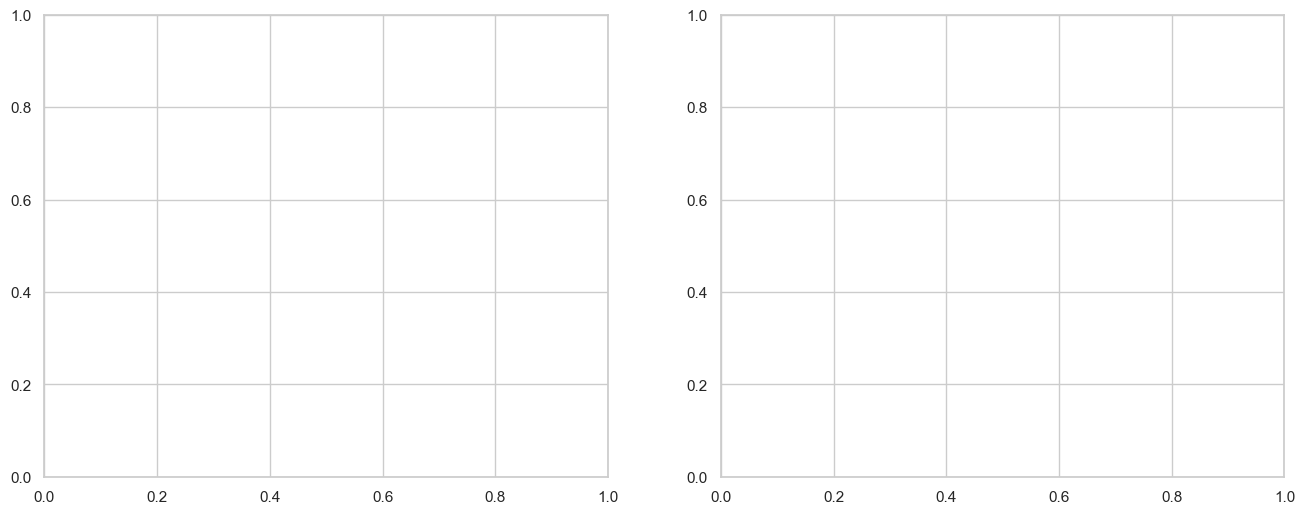

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Scatter Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot for Average Age vs Number of Drafted Players
sns.scatterplot(data=final_df_v2, x='Age_Years', y='Drafted', hue='School', ax=axes[0])
axes[0].set_title('Average Age vs Number of Drafted Players by Team')
axes[0].set_xlabel('Average Age (Years)')
axes[0].set_ylabel('Number of Drafted Players')

# Scatter plot for Average Experience vs Draft Quality
sns.scatterplot(data=final_df_v2, x='year_exp', y='Team_Draft_Score', hue='School', ax=axes[1])
axes[1].set_title('Average Experience vs Draft Quality by Team')
axes[1].set_xlabel('Average Experience (Years)')
axes[1].set_ylabel('Draft Quality Score')

# Drop legends
axes[0].get_legend().remove()
axes[1].get_legend().remove()
plt.tight_layout()
plt.show()

# # Correlation Heatmap
# # Selecting only numerical columns for correlation
# correlation_df = final_df_v2.select_dtypes(include=[np.number])

# plt.figure(figsize=(14, 10))
# sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm')
# plt.title('Correlation Heatmap')
# plt.show()


### Refactor to Single Function v1

## Group by Team and claculate the average age in Years